In [59]:
import numpy as np
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt

# Decision Tree Class

In [60]:
"""
Decision Tree class:
    Used information gain to split the data to make effecient catogories. 
    The user can select the depth and the minimum sample split parameter

"""

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold # Will be used to check which side of the tree should be searched
        self.left = left 
        self.right = right
        self.value = value
         
            
    def is_leaf_node(self): # Will be used to check if it is a leaf node
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split = 2, max_depth = 5, random_forest = 0):
        self.min_samples_split=min_samples_split # Another Hyper parameter set in order to avoid overfitting 
        self.max_depth=max_depth # Adding a hyperparameter to prevent the tree from overfitting
        self.root=None 
        self.random_forest = random_forest

    def fit(self, X, y): # Fit Function
        self.root = self.build_tree(X, y)

 
    def gini_impurity(self, y):# Purity Function to measure how pure a split is
        hist = np.bincount(y.astype(int))
        #hist = np.bincount(y) # Bincount returns the fraction of each label in a dataset
        ps = hist / len(y)
        return np.sum([p*(1-p) for p in ps if p>0]) 



    def get_best_split(self, X, y, number_features): # Function to calculate the best split, using information gain
        
        split_at_feature = 0
        split_at_value = 0
        current_gain = 0 # Will be used to compare the IG of different datasets
        
        for feature_index in number_features:  # For loop iterates through each feature in the dataset
            column_feature = X[:, feature_index]   # Extracting the values of the chosen feature
            feature_data = np.unique(column_feature)
          
            for data_value in feature_data: # For loop iterates through each value in the feature
                
                gain = self.information_gain(y, column_feature, data_value) # Returns the IG if the split was to happen in this feature, around the data_value

                if gain > current_gain: #If IG is higher than previous split, it variables is updated and the split occurs at this feature and value 
                    current_gain = gain
                    split_at_feature = feature_index
                    split_at_value = data_value
                   

        return split_at_feature, split_at_value


    def information_gain(self, y, column_feature, data_value):
       
        parent_entropy = self.gini_impurity(y)  # Parent entropy, getting the impurity of the original(before split) dataset

        left_index, right_index = self.split(column_feature, data_value) # Creating a split in the column feature using the value in the column, recieved from get_best_split 
        if len(left_index) == 0 or len(right_index) == 0: 
            return 0
        
        # Calculate the impurity of the potential splits
        
        number_samples = len(y) # Getting the total number of samples in the potential split
        samples_left = len(left_index) # Left child
        samples_right=  len(right_index) # Right child
        gini_left = self.gini_impurity(y[left_index]) 
        gini_right = self.gini_impurity(y[right_index]) 
        

        child_purity = (samples_left/number_samples) * gini_left + (samples_right/number_samples) * gini_right

        # Calculating the Info Gain 
        information_gain = parent_entropy - child_purity
        return information_gain

    def split(self, column_feature, data_value):
        #Creating potential children
        left_child = np.argwhere(column_feature <= data_value).flatten()
        right_child = np.argwhere(column_feature > data_value).flatten()
        return left_child, right_child
    
        
    
    def build_tree(self, X, y, current_depth=0):
        number_samples,number_features = X.shape # shape() Returns (no.samples, no.features)
        number_labels = len(np.unique(y)) # To be used as a stopping condition for the tree

        
        if (current_depth >= self.max_depth or number_labels == 1 or number_samples < self.min_samples_split): # Checking the hyperparameters set, if the tree has exceding the hyper-parameters or not
            leaf_value = self.most_common_label(y) # Gets the most common label
            return Node(value=leaf_value)

        # Getting the best split using info gain
        if self.random_forest==0:
            number_feat = np.random.choice(number_features, number_features, replace=False) 
            best_feature, best_value = self.get_best_split(X, y, number_feat)
        else:
            number_feat = np.random.choice(number_features, 4, replace=False) # If random forest is used, random root(no.features) to be sampled at each node
            best_feature, best_value = self.get_best_split(X, y, number_feat)
            

       
        # After getting the best feature and value, using it to for a new node in the tree
    
        left_child, right_child = self.split(X[:, best_feature], best_value)  
        left = self.build_tree(X[left_child, :], y[left_child], current_depth+1)
        right = self.build_tree(X[right_child, :], y[right_child], current_depth+1)
        return Node(best_feature, best_value, left, right)


    def predict(self, X): # Predict function which gets the test samples in order to use the tree and make a prediction
        y_pred = np.array([self.make_prediction(x, self.root) for x in X])
        return y_pred

    def make_prediction(self, x, node): # Function will go through the tree and predict the label
        if node.is_leaf_node(): # Checks if its the last node, then returns the value, which will be the most common label
            return node.value
        
        feature_value = x[node.feature] # Getting the best feature from the test sample. (Calculated earlier)
    
        if feature_value <= node.threshold: # Checking which side/split of the tree to search by comparing it to the threshold value calculated earlier
            
            return self.make_prediction(x, node.left) #If smaller or equal to the threshold (value used to split) than will go through left side
        return self.make_prediction(x, node.right) # Else it will go through the right side
        
    
    def most_common_label(self, y): 
        counter = Counter(y)
        if counter:
            prediction = counter.most_common(1)[0][0]
            return prediction
        else:
            return None
    
    def accuracy(self, y_true, y_pred):
        #Calculates the accuracy by dividing the correct labels by the total number of labels in test sample
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy

# Random Forest Class

In [61]:
"""
Random Forest class:
    Generetes bootsrapped samples which are used to make multiple decision
    trees depedning on the 'no_trees' paramter selected by the user.

"""

import numpy as np
from collections import Counter

class RandomForest:
    
    def __init__(self, no_trees=2, max_depth = 3, min_sample_split = 2):
        self.no_trees = no_trees
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.trees = []
        
        
    def fit(self,X,y):
        self.trees = []
        for i in range (0, self.no_trees):
            tree = DecisionTree(self.max_depth, self.min_sample_split, random_forest = 1)
            X_bootstrapped, Y_bootstrapped = self.bagging(X,y) 
            tree.fit(X_bootstrapped, Y_bootstrapped)
            self.trees.append(tree)

    
    def bagging(self, X, y):
        bootstrap_idx = np.random.choice(X.shape[0], X.shape[0]) 
        X_bootstrap = X[bootstrap_idx] 
        Y_bootstrap = y[bootstrap_idx]
        return X_bootstrap, Y_bootstrap
    
    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.trees]) 
        #print("These are the tree predictions: ",tree_predictions)
        label_predictions = np.transpose(tree_predictions) 
        #print("These are the labels from each prediction ",label_predictions)

        predictions = np.array([self.most_common_label(prediction) for prediction in label_predictions]) 
        return predictions
    
        
    def most_common_label(self, y): # For classificaiton problem, highest vote function
        counter = Counter(y)
        prediction = counter.most_common(1)[0][0] 
        return prediction

    def accuracy (self, y_true, y_pred): # Accuracy Function, checks the total no. of correctly predicted labels / total number of lables
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy
        

# Cross Validation Function

In [62]:
"""
Cross Validation function 
Splits the data into the required folds and returns the accuracy result of each fold

"""

def cross_validation(predictor, x, y, folds=10):
    number_samples = len(y)
    fold_size = int(number_samples / folds) #int is used so we dont get float values, rounds the number down if float
    accuracy_scores = []
    for i in range(0,folds):
        # split data into train and test
        start = i * fold_size      # Each iteration will change the start and end point to make the new folds. The next iteration the start will be where the previous ended
        end = start + fold_size    
        x_test = x[start:end]      # Making a test samples of for each fold
        y_test = y[start:end] 
        
        x_train_data = np.concatenate((x[:start], x[end:]), axis=0)  # Joining the rest of the data together, which isn't in the test samples to make training sets
        x_train = x_train_data
        y_train_data = np.concatenate((y[:start], y[end:]), axis=0)
        y_train=y_train_data
        
        
        predictor.fit(x_train, y_train)       # Using the predictor algorithm to make predictions and then store the prediction scores in the accuracy array
        y_pred = predictor.predict(x_test)
        acc = predictor.accuracy(y_test,y_pred)
        accuracy_scores.append(acc)
    return np.array(accuracy_scores)

# Acessing Heart Failure Clinical Records

In [110]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np



data = pd.read_csv('heart_failure_clinical_records_dataset.csv') # Access the data
train_set, test_set = train_test_split(data, test_size = 0.2, random_state = 27) # Splits the data randomly

#Extracting the Target/Label and feature (y,x) set for training and test sample

y_train_data = train_set["DEATH_EVENT"] 
x_train_data = train_set.drop("DEATH_EVENT", axis=1)
y_test_data = test_set['DEATH_EVENT']
x_test_data = test_set.drop("DEATH_EVENT", axis=1)
    
    
y_train =  y_train_data.values
x_train =  x_train_data.values
y_test =  y_test_data.values
x_test =  x_test_data.values


## Testing DecisionTree on the Heart Failure Clinical Records:
#### Parameters can be changed to see how the accuracy score is affected


In [87]:
clf = DecisionTree(min_samples_split = 2, max_depth = 1)
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Accuracy: ",clf.accuracy(y_test, pred))

Accuracy:  0.8666666666666667


### Graph representation of the effect of maximum depth parameter on the accuracy of decisionTree:

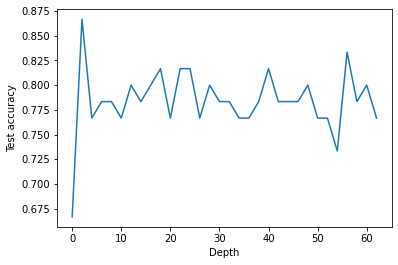

In [88]:
test_acc_depth = []  

for depth in range(0,63,2):
    clf2 = DecisionTree(max_depth=depth)
    clf2.fit(x_train,y_train)
    prediction = clf2.predict(x_test)
    acc=clf2.accuracy(y_test,prediction)
    test_acc_depth.append(acc)   
    
plt.plot([i*1 for i in range(0, 63,2)], test_acc_depth)
plt.xlabel("Depth")
plt.ylabel("Test accuracy")
plt.show()

### Checking the accuracy of decisionTree by changing the minimum samples split parameter:

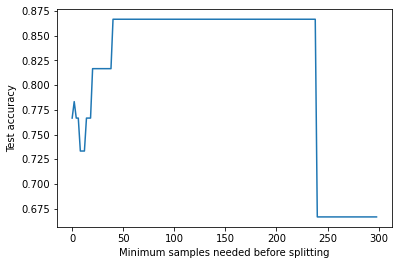

In [67]:
test_acc_depth = []  

for split in range(0,299,2):
    clf2 = DecisionTree(min_samples_split=split)
    clf2.fit(x_train,y_train)
    prediction = clf2.predict(x_test)
    acc=clf2.accuracy(y_test,prediction)
    test_acc_depth.append(acc)   
    
plt.plot([i*1 for i in range(0, 299,2)], test_acc_depth)
plt.xlabel("Minimum samples needed before splitting")
plt.ylabel("Test accuracy")
plt.show()

# Testing RandomForest on the Heart Failure Clinical Records: 
#### Parameters can be changed to see how the accuracy score is affected


In [120]:
clf = RandomForest(no_trees=29, max_depth = 10, min_sample_split = 2)
clf.fit(x_train,y_train)
predictions = clf.predict(x_test)
acc=clf.accuracy(y_test,predictions)
print(acc)

0.85


## Graphs on the affects of number of trees and depth of the trees on the accuracy of the RandomForest: 

<ipython-input-61-15a4b37f57b1>:51: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = np.sum(y_true == y_pred) / len(y_true)


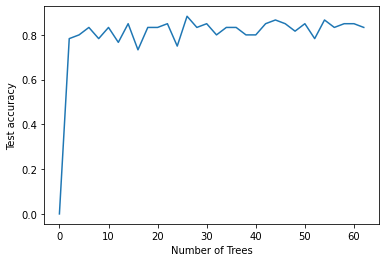

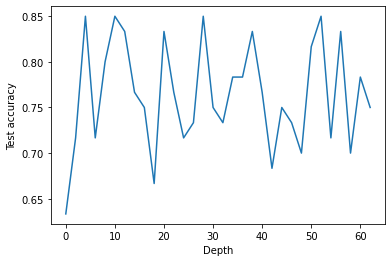

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt

test_acc_no_trees = []
for tree in range(0,63,2):
    clf = RandomForest(no_trees=tree)
    clf.fit(x_train,y_train)
    predictions = clf.predict(x_test)
    acc=clf.accuracy(y_test,predictions)
    test_acc_no_trees.append(acc)
    
    
test_acc_depth = []  

for depth in range(0,63,2):
    clf2 = RandomForest(max_depth=depth)
    clf2.fit(x_train,y_train)
    prediction = clf2.predict(x_test)
    acc=clf2.accuracy(y_test,prediction)
    test_acc_depth.append(acc)   
    
plt.plot([i*1 for i in range(0, 63,2)], test_acc_no_trees)
plt.xlabel("Number of Trees")
plt.ylabel("Test accuracy")
plt.show()

plt.plot([i*1 for i in range(0, 63,2)], test_acc_depth)
plt.xlabel("Depth")
plt.ylabel("Test accuracy")
plt.show()

## Cross Validation testing with the DecisionTree
#### Parameters can be adjusted to test different parameters of the algorithm with cross validation or test with different number of folds

In [91]:
y = data["DEATH_EVENT"]
x = data.drop("DEATH_EVENT", axis=1)
y_labels = y.values
x_features = x.values


######structure of the class: DecisionTree(min_samples_split, max_depth) || if user wishes to test other parameters
dt = DecisionTree(max_depth = 1) 
scores = cross_validation(dt, x_features, y_labels, folds = 10)
print("Cross validation scores:", scores)
print("Mean accuracy:", np.mean(scores))

Cross validation scores: [0.89655172 0.82758621 0.48275862 0.86206897 0.82758621 0.79310345
 0.68965517 0.86206897 0.96551724 0.93103448]
Mean accuracy: 0.8137931034482758


## Cross Validation with RandomForest
#### Parameters can be adjusted to test different parameters of the algorithm with cross validation or test with different number of folds

In [94]:
y = data["DEATH_EVENT"]
x = data.drop("DEATH_EVENT", axis=1)
y_labels = y.values
x_features = x.values


######structure of the class: RandomForest(no_trees, max_depth, min_sample_split) || if user wishes to test other parameters
rf = RandomForest(no_trees = 29, max_depth = 1) # setting the depth of each tree in the random forest to 1 and then testing the algorithm
scores = cross_validation(rf, x_features, y_labels, folds = 10)
print("Cross validation scores:", scores)
print("Mean accuracy:", np.mean(scores))

Cross validation scores: [0.68965517 0.82758621 0.51724138 0.86206897 0.82758621 0.82758621
 0.68965517 0.89655172 0.96551724 0.93103448]
Mean accuracy: 0.8034482758620689


# 

# Below cells perform the calculations on the FETAL HEALTH dataset

## Accessing Dataset 2: Fetal Health DataSet

In [95]:
data2 = pd.read_csv('fetal_health.csv')
train_set, test_set = train_test_split(data2, test_size = 0.2, random_state = 27)
y_train_data = train_set["fetal_health"] # Getting the labels for training set which is stored under DEATH_EVENT
x_train_data = train_set.drop("fetal_health", axis=1) #Getting the features for training set by removing the label column

# Extracting the features and labels for the test samples
y_test_data = test_set['fetal_health']
x_test_data = test_set.drop("fetal_health", axis=1)
  
# Extracting the values from the dataset    
y_train =  y_train_data.values
x_train =  x_train_data.values
y_test =  y_test_data.values
x_test =  x_test_data.values

## Testing the DecisionTree on the second dataset: 
#### Parameters can be changed to see how the accuracy score is affected


In [97]:
clf3 = DecisionTree(min_samples_split = 2, max_depth = 13)
clf3.fit(x_train,y_train)
prediction = clf3.predict(x_test)
acc=clf3.accuracy(y_test,prediction)
print("Accuracy: ",acc)

Accuracy:  0.9154929577464789


### Graphs on how maximum depth effects the accuracy score for the second dataset:


<ipython-input-156-a0692ef81cfd>:140: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = np.sum(y_true == y_pred) / len(y_true)


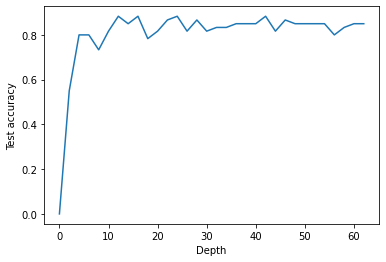

In [175]:
test_acc_depth = []  

for depth in range(0,63,2):
    clf3 = DecisionTree(max_depth=depth)
    clf3.fit(X_train,y_train)
    prediction = clf3.predict(X_test)
    acc=clf3.accuracy(y_test,prediction)
    test_acc_depth.append(acc)   
    
plt.plot([i*1 for i in range(0, 63,2)], test_acc_no_trees)
plt.xlabel("Depth")
plt.ylabel("Test accuracy")
plt.show()

## Testing the RandomForest on the second dataset: 
#### Parameters can be changed to see how the accuracy score is affected



In [80]:
clf4 = RandomForest(no_trees=6, max_depth = 16, min_sample_split = 2)
clf4.fit(x_train,y_train)
pred = clf4.predict(x_test)
print("Accuracy: ",clf4.accuracy(y_test, pred))

Accuracy:  0.8403755868544601


###      Graphs on the effects of number of trees and depth of the trees on the accuracy of the RandomForest: 

<ipython-input-97-ca5efc0d1029>:44: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = np.sum(y_true == y_pred) / len(y_true)


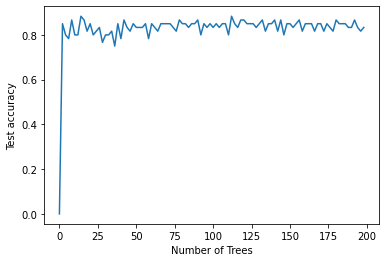

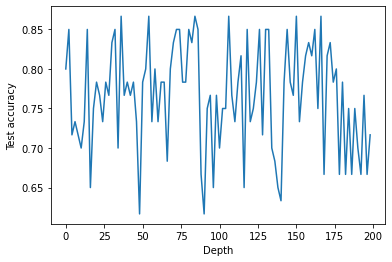

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt

test_acc_no_trees = []
for tree in range(0,200,2):
    clf = RandomForest(no_trees=tree)
    clf.fit(x_train,y_train)
    predictions = clf.predict(x_test)
    acc=clf.accuracy(y_test,predictions)
    test_acc_no_trees.append(acc)
    
    
test_acc_depth = []  

for depth in range(0,200,2):
    clf2 = RandomForest(max_depth=depth)
    clf2.fit(x_train,y_train)
    prediction = clf2.predict(x_test)
    acc=clf2.accuracy(y_test,prediction)
    test_acc_depth.append(acc)   
    
plt.plot([i*1 for i in range(0, 200,2)], test_acc_no_trees)
plt.xlabel("Number of Trees")
plt.ylabel("Test accuracy")
plt.show()

plt.plot([i*1 for i in range(0, 200,2)], test_acc_depth)
plt.xlabel("Depth")
plt.ylabel("Test accuracy")
plt.show()


## Cross Validation testing with the DecisionTree
#### Folds Parameters can be changed to changed the numbers of folds to use in the cross-validation

In [98]:
y = data2["fetal_health"]
x = data2.drop("fetal_health", axis=1)
y_labels = y.values
x_features = x.values

######structure of the class: DecisionTree(min_samples_split, max_depth) || if user wishes to test other parameters
dt = DecisionTree(max_depth = 13)
scores = cross_validation(dt, x_features, y_labels, folds = 5)
print("Cross validation scores:", scores)
print("Mean accuracy:", np.mean(scores))

Cross validation scores: [0.87529412 0.84941176 0.98352941 0.83294118 0.71058824]
Mean accuracy: 0.8503529411764706


## Cross Validation testing with the Random Forest
#### Folds Parameters can be changed to changed the numbers of folds to use in the cross-validation

In [107]:
y = data2["fetal_health"]
x = data2.drop("fetal_health", axis=1)
y_labels = y.values
x_features = x.values

######structure of the class: RandomForest(no_trees, max_depth, min_sample_split) || if user wishes to test other parameters
rf = RandomForest(no_trees = 10)
scores = cross_validation(rf, x_features, y_labels, folds = 5)
print("Cross validation scores:", scores)
print("Mean accuracy:", np.mean(scores))

Cross validation scores: [0.62588235 0.74352941 0.99294118 0.88705882 0.77176471]
Mean accuracy: 0.8042352941176472
